# Summary of ENA Data

In [1]:
import os

import numpy as np
import pandas as pd
import toolbox as tbx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [2]:
data_directory = os.path.join(os.getenv("HOME"), 'Research', 'data', 'ENA')

ccn_directory = os.path.join(data_directory, 'ccn')
ccn_h5file = os.path.join(ccn_directory, 'enaaosccn.h5')
has_ccn_h5file = os.path.isfile(ccn_h5file)

met_directory = os.path.join(data_directory, 'met')
met_h5file = os.path.join(met_directory, 'enamet.h5')
has_met_h5file = os.path.isfile(met_h5file)

results="""\
DATA Parent Directory: {}

CCN Data Directory: {}
    Directory Exists ==>  {}
    HDF5 File Found  ==>  {}

MET Data Directory: {}
    Directory Exists ==>  {}
    HDF5 File Found  ==>  {}
""".format(data_directory, 
           ccn_directory, os.path.isdir(ccn_directory), has_ccn_h5file,
           met_directory, os.path.isdir(met_directory), has_met_h5file)

print(results)

DATA Parent Directory: /home/jstemm/Research/data/ENA

CCN Data Directory: /home/jstemm/Research/data/ENA/ccn
    Directory Exists ==>  True
    HDF5 File Found  ==>  True

MET Data Directory: /home/jstemm/Research/data/ENA/met
    Directory Exists ==>  True
    HDF5 File Found  ==>  True



In [3]:
if has_ccn_h5file:
    CCN = tbx.fileIO.HDF.read_file(ccn_h5file).data
else:
    CCND = tbx.fileIO.NetCDFFolder(ccn_directory)
    CCND.summary()
    CCN = CCND.process(varlist=('N_CCN', 'CCN_ss_set', 'CCN_supersaturation_set_point'),
                       mapping={'N_CCN': 'CCN', 'CCN_ss_set': 'SS',
                                'CCN_supersaturation_set_point': 'SS'},
                       savefile=ccn_h5file)
print(CCN.head())

                            CCN   SS
2014-04-14 00:00:00  110.591660  0.5
2014-04-14 00:00:01  136.116165  0.5
2014-04-14 00:00:02  120.743423  0.5
2014-04-14 00:00:03  150.815201  0.5
2014-04-14 00:00:04  142.145920  0.5


In [4]:
if has_met_h5file:
    MET = tbx.fileIO.HDF.read_file(met_h5file).data
else:
    METD = tbx.fileIO.NetCDFFolder(met_directory)
    METD.summary()
    MET = METD.process(varlist=('atmos_pressure', 'temp_mean', 'wdir_vec_mean', 'wspd_vec_mean'),
                      savefile=met_h5file)
print(MET.head())

                     atmos_pressure  temp_mean  wdir_vec_mean  wspd_vec_mean
2014-03-01 00:00:00      102.989998      15.39     237.000000          6.302
2014-03-01 00:01:00      102.989998      15.37     233.100006          7.139
2014-03-01 00:02:00      102.989998      15.37     234.199997          5.598
2014-03-01 00:03:00      102.989998      15.40     235.899994          7.112
2014-03-01 00:04:00      102.989998      15.39     233.600006          6.853


In [5]:
ccn = CCN.CCN
ss = CCN.SS

print('First Record: {}'.format(CCN.index[0]))
print('Last Record:  {}'.format(CCN.index[-1]))
print('Total Span:   {}'.format(CCN.index[-1]-CCN.index[0]))

print(CCN.describe())

ss_vals = set()
[ss_vals.add(i) for i in ss]
print("Unique SuperSaturation Values:")
print(sorted(ss_vals))

First Record: 2014-04-14 00:00:00
Last Record:  2015-01-18 23:59:59
Total Span:   279 days 23:59:59
                   CCN               SS
count  47882048.000000  47882048.000000
mean        199.091493         0.433776
std         273.856718         0.367978
min           0.000000         0.000000
25%          67.768051         0.100000
50%         151.128723         0.500000
75%         266.481934         0.800000
max       41218.078125         1.000000
Unique SuperSaturation Values:
[0.0, 0.1, 0.2, 0.40000001, 0.5, 0.51537198, 0.52848297, 0.53325701, 0.551934, 0.56267601, 0.56344098, 0.56487101, 0.58180898, 0.59178501, 0.59943902, 0.60000002, 0.61326897, 0.615996, 0.62585998, 0.64457202, 0.80000001, 1.0]


In [6]:
# set the supersaturation value
ss_val = 0.1

[5, 25, 50, 75, 95]


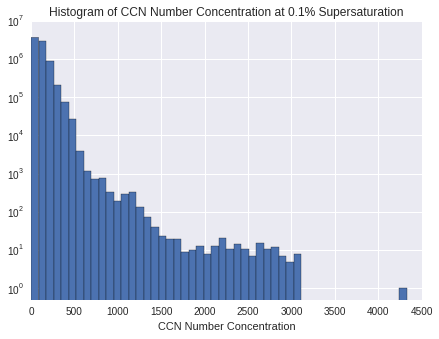

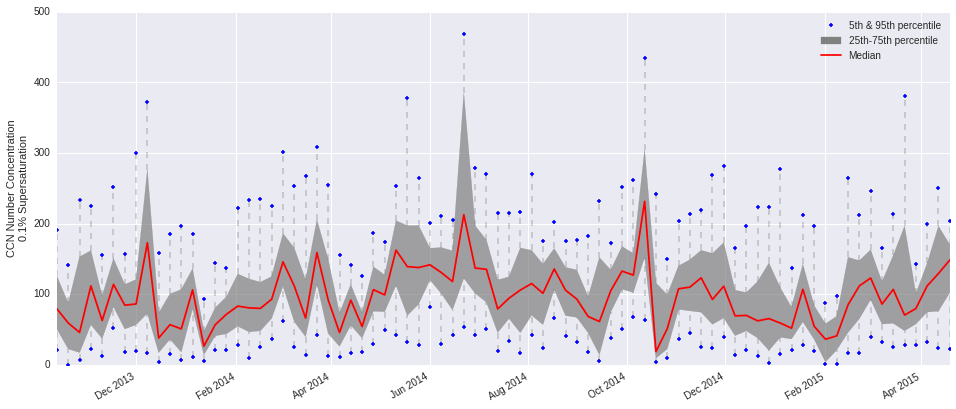

In [11]:
fig, ax1 = plt.subplots(figsize=(7, 5))
ccn[ss==ss_val].hist(ax=ax1, bins=50)#np.arange(0, 1000, 50))
ax1.set_title('Histogram of CCN Number Concentration at {}% Supersaturation'.format(ss_val))
ax1.set_xlabel('CCN Number Concentration')
ax1.set_yscale('log')
ax1.set_ylim(bottom=0.5)

fig, ax = plt.subplots(figsize=(16, 7))
fig, ax = tbx.plotting.series.filled_series(ccn[ss==ss_val], fig=fig, ax=ax)
ax.set_ylabel('CCN Number Concentration\n{}% Supersaturation'.format(ss_val))

[5, 25, 50, 75, 95]


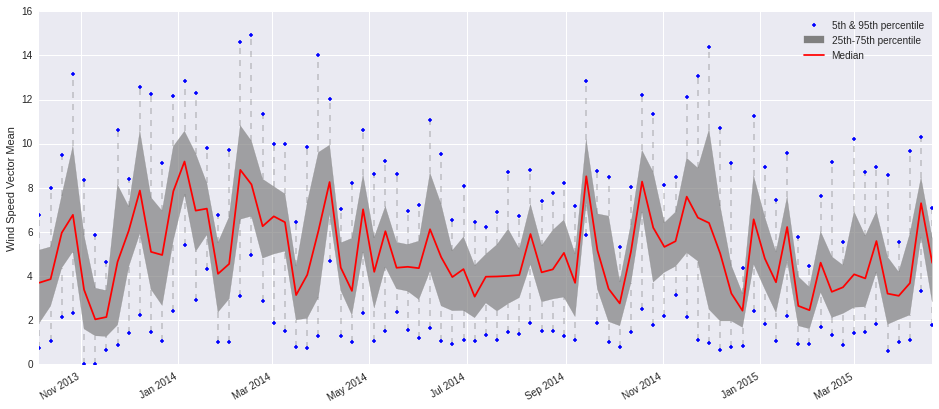

In [14]:
fig, ax = tbx.plotting.series.filled_series(MET['wspd_vec_mean'])
ax.set_ylabel('Wind Speed Vector Mean')